In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-walmart-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-walmart-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in data.keys():
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-walmart-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-walmart-reduced/glove-300.matrix.npy',
                        text_columns = ['brand', 'groupname', 'title', 'shelfdescr',
                                        'shortdescr', 'longdescr'],
                        numeric_columns = ['price', 'shipweight', 'length', 'width', 'height'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['inverse_l1', 'cosine'],
                        text_compositions=['average', 'idf', 'bi_lstm'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        dropout=0.75,
                        batch_norm=True,
                        lstm_args=dict(units=20, dropout=0.25, recurrent_dropout=0.25),
                        shared_lstm=True,
                        embedding_trainable=True)

Number of inputs to dense layer: 205


# Crash recovery 

In [ ]:
model.load_weights('../data/models/amazon-walmart-all-reduced')
df_hist = pd.read_csv('../data/histories/amazon-walmart-all-reduced.csv')

histories['acc'] = list(df_hist['acc'].values)
histories['val_acc'] = list(df_hist['val_acc'].values)
histories['loss'] = list(df_hist['loss'].values)
histories['val_loss'] = list(df_hist['val_loss'].values)

# Train model 

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=1024,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 93243 samples, validate on 11656 samples
Epoch 1/1
93243/93243 [==============================] - 537s 6ms/step - loss: 0.0105 - acc: 0.9978 - val_loss: 0.0133 - val_acc: 0.9978


# Learning curves

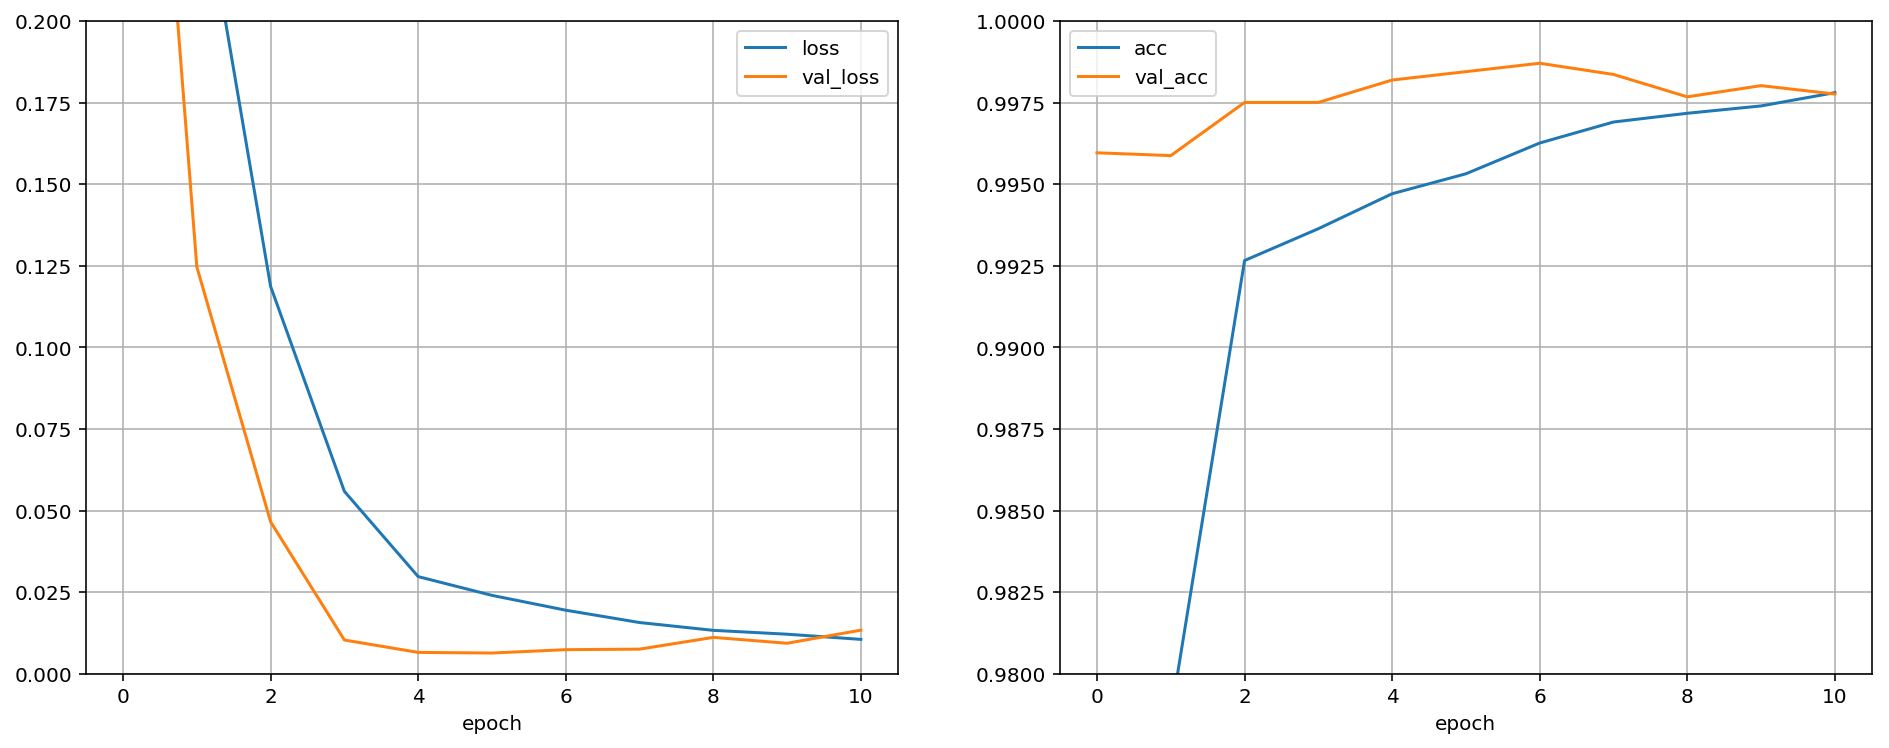

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set(ylim = (0, 0.2))
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set(ylim = (0.98, 1))

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [43]:
y_val_pred = model.predict(X_val, batch_size=4096)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11529
          1       0.90      0.96      0.93       127

avg / total       1.00      1.00      1.00     11656

[[11515    14]
 [    5   122]]


In [44]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & (y_val_pred >= 0.5)
columns = ['brand', 'groupname', 'title', 'shelfdescr',
           'shortdescr', 'longdescr']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(10)

,id1,brand,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,...,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,width,height
1910,11885,green,laptop netbook computer accessories,green onions supply screen protector for wide laptop lcd screen piece transparent,39.95,sold individually,nan,screen protector for 17 laptop lcd screen product details this is lcd screen protector suited to fit 17 lcd screens or 17 apple the silicone glue allows for easy attachment while the micro fiber cloth allows for quick cleaning before placement of screen unique company features the surface reduces the glare when viewing the screen under strong light the hard coating 3h protects the screen from the liner contains release tab all of which is silicone glued onto the screen protector which makes it easy to peel the silicone glue makes for easy attachment or reapplying of keeps oil and fingerprints off lcd while in each pack includes screen protector and micro fiber wiping customer service support information toll free product specifications content one 17 screen protector with high quality japanese made micro fiber dimensions 14 20 32 33 367mm 228mm thickness mm mil,0.0,15.2,...,electronics general,green onions supply screen protector for wide laptop lcd screen piece transparent,32.88,fits 17 laptops or macbooks reduces lighting problems on reflective screens includes cleaning cloth,screen protector for 17 laptop lcd screen is an lcd screen protector suited to fit 17 lcd screens or 17 apple the silicone glue allows for easy attachment while the micro fiber cloth allows for quick cleaning before placement of screen the surface reduces the glare when viewing the screen under strong light hard coating protects the screen from the liner contains release tab all of which is silicone glued onto the screen protector which makes it easy to peel keeps oil and fingerprints off lcd while in each pack includes screen protector and micro fiber wiping,key features fits 17 laptops or macbooks reduces lighting problems on reflective screens material pet film with silicone glue protects screen includes cleaning cloth,0.000,0.00,0.0,0.00
7803,16033,svat,electronics,svat digital wireless dvr security system with sd card recording long range night visi,438.72,wireless system allows for easy gb secure digital card records up to 350 minutes of continuos wireless camera has 18 infrared leds to allow up to night vision protective aluminum housing allows system to be used year round indoors amp expandable up to,nan,wireless system allows for easy setup2 gb secure digital card records up to 350 minutes of continuos footagewireless camera has 18 infrared leds to allow up to night vision rangeprotective aluminum housing allows system to be used year round indoors amp outdoorsexpandable up to camerasadvanced settings24 hour recording amp remote control access to adjust settings amp recording schedules24 lifetime live customer supportreceiverupc 871363012081shipping dimensions shipping weight,0.0,0.0,...,garden general,svat digital wireless dvr security system with receiver sd card recording and long range night vision cameras,249.82,record up to 350 min of video and audio on included 2gb sd card advanced motion detection settings includes remote control,svat digital wireless dvr security system can be used to monitor and record video and audio in any indoor or outdoor space at any time of the this wireless plug and play system allows for easy set up in matter of minutes and the included 2gb sd card can record up to 350 minutes of continuous audio and video the wireless weather resistant camera included with this system has 18 infrared leds that allow you to see up to 40 away in the ideal for monitoring entrances backyards valuables and employees the system can be used in any situation you,svat digital wireless dvr security system with receiver and long range night vision cameras record up to 350 min of video and audio on included 2

# Save model and histories 

In [45]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-walmart-all-reduced.csv', index=False)
model.save_weights('../data/models/amazon-walmart-all-reduced')

# Test model 

In [46]:
y_test_pred = model.predict(X_test, batch_size=4096)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11541
          1       0.85      0.91      0.88       114

avg / total       1.00      1.00      1.00     11655

[[11523    18]
 [   10   104]]
